In [18]:
# Imports functions into the program
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Imported for categorization of the Sources
from scipy import stats
import astropy.stats as ast
from astropy.visualization import hist
import urllib.request
import lmfit
from importlib import reload

# Import from BB analysis github
import HopFinder
import HOP
import LC
import LC_Set
from fermi_catalog import select_bll, select_fsrq, select_bcu

# COSI Analysis

## Daily

In [133]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'daily'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [160]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 22 #Counts / s


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=0,y2=1e-8,color='y',alpha=0.6,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=0,y2=1e-8,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=0,y2=1e-8,color='y',alpha=0.6,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        background_counts = COSI_bkg_rate * duration
        integral = np.sum(temp_sum)
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,integral,duration]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,integral,duration,background_counts]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts)
    
    return mdp99

In [158]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]/100

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,2]
        background_counts = flarestack[:,3]

        COSI_BAND = np.array([flarenames, flareintegrals,flareduration,background_counts]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_daily_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_daily_df.columns=['Name','Photon Counts','Duration (s)','Background Counts']

COSI_BAND_ALL_daily_df


0
9.96e-07 6.39e-09 9.8961e-07 9.896100000000001e-08 1.05351e-07
<class 'list'>
 
[['0' '0' '0' '0']
 ['4FGL J0538.8-4405' '8.01767808' '25531200.0' '561686400.0']
 ['4FGL J0538.8-4405' '32.26073184' '81388800.0' '1790553600.0']
 ['4FGL J0538.8-4405' '9.00528192' '56246400.0' '1237420800.0']
 ['4FGL J0538.8-4405' '1.94819904' '16848000.0' '370656000.0']
 ['4FGL J0538.8-4405' '0.98467488' '8035200.0' '176774400.0']
 ['4FGL J0538.8-4405' '2.6540265599999997' '22939200.0' '504662400.0']
 ['4FGL J0538.8-4405' '1.4440291200000002' '14644800.0' '322185600.0']
 ['4FGL J0538.8-4405' '2.1941020799999995' '10238400.0' '225244800.0']
 ['4FGL J0538.8-4405' '8.858471040000001' '47952000.0' '1054944000.0']
 ['4FGL J0538.8-4405' '0.53034912' '3888000.0' '85536000.0']
 ['4FGL J0538.8-4405' '1.5995232' '8812800.0' '193881600.0']
 ['4FGL J0538.8-4405' '9.3453264' '38620800.0' '849657600.0']]
aaaaaaa
[  0.         150.20711668 604.38838569 168.70937179  36.4985171
  18.44738254  49.72183632  27.05315035 

Name       Photon Counts Duration (s) Background Counts
0                    0                   0            0                 0
1                    0                 0.0            0                 0
2    4FGL J0538.8-4405  150.20711668253008   25531200.0       561686400.0
3    4FGL J0538.8-4405    604.388385690174   81388800.0      1790553600.0
4    4FGL J0538.8-4405  168.70937179315118   56246400.0      1237420800.0
..                 ...                 ...          ...               ...
735  4FGL J0428.6-3756  0.3445793415740104     518400.0        11404800.0
736  4FGL J0428.6-3756   7.202721707548504    7516800.0       165369600.0
737  4FGL J0428.6-3756    6.56052040526204    7257600.0       159667200.0
738  4FGL J0428.6-3756  2.5556301166739104    3888000.0        85536000.0
739  4FGL J0428.6-3756  10.116106258268374   13996800.0       307929600.0

[740 rows x 4 columns]

In [ ]:
COSI_BAND_ALL_daily_df = COSI_BAND_ALL_daily_df[COSI_BAND_ALL_daily_df[:]['Photon Counts']!='0'].reset_index(drop=True)
COSI_BAND_ALL_daily_df = COSI_BAND_ALL_daily_df[COSI_BAND_ALL_daily_df[:]['Photon Counts']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_daily_df['Photon Counts']= COSI_BAND_ALL_daily_df['Photon Counts'].astype(float)
COSI_BAND_ALL_daily_df['Duration (days)'] = COSI_BAND_ALL_daily_df['Duration (s)'].astype(float)/(86400)
COSI_BAND_ALL_daily_df['MDP99'] = ComputeMDP99(COSI_BAND_ALL_weekly_df['Photon Counts'],COSI)


#pd.set_option('display.max_rows',None)
#pd.set_option('display.max_columns',None)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
COSI_BAND_ALL_daily_df

Name  Photon Counts Duration (s) Background Counts  \
0    4FGL J0538.8-4405     150.207117   25531200.0       561686400.0   
1    4FGL J0538.8-4405     604.388386   81388800.0      1790553600.0   
2    4FGL J0538.8-4405     168.709372   56246400.0      1237420800.0   
3    4FGL J0538.8-4405      36.498517   16848000.0       370656000.0   
4    4FGL J0538.8-4405      18.447383    8035200.0       176774400.0   
..                 ...            ...          ...               ...   
578  4FGL J0428.6-3756       0.344579     518400.0        11404800.0   
579  4FGL J0428.6-3756       7.202722    7516800.0       165369600.0   
580  4FGL J0428.6-3756       6.560520    7257600.0       159667200.0   
581  4FGL J0428.6-3756       2.555630    3888000.0        85536000.0   
582  4FGL J0428.6-3756      10.116106   13996800.0       307929600.0   

     Duration (days)  
0              295.5  
1              942.0  
2              651.0  
3              195.0  
4               93.0  
..               ...  
578              6.0  
579             87.0  
580             84.0  
581             45.0  
582            162.0  

[583 rows x 5 columns]

In [137]:
print(COSI_BAND_ALL_daily_df.dtypes)

Name             object
Photons         float64
Duration (s)    float64
dtype: object


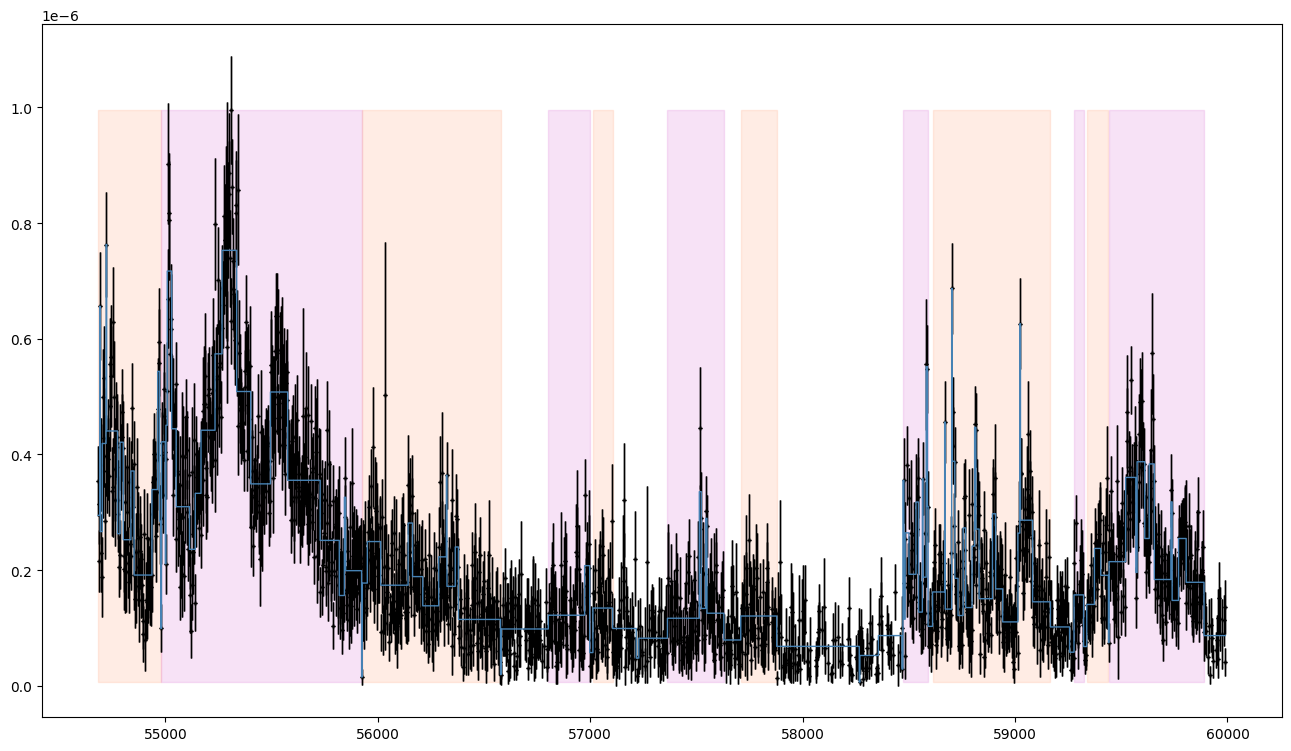

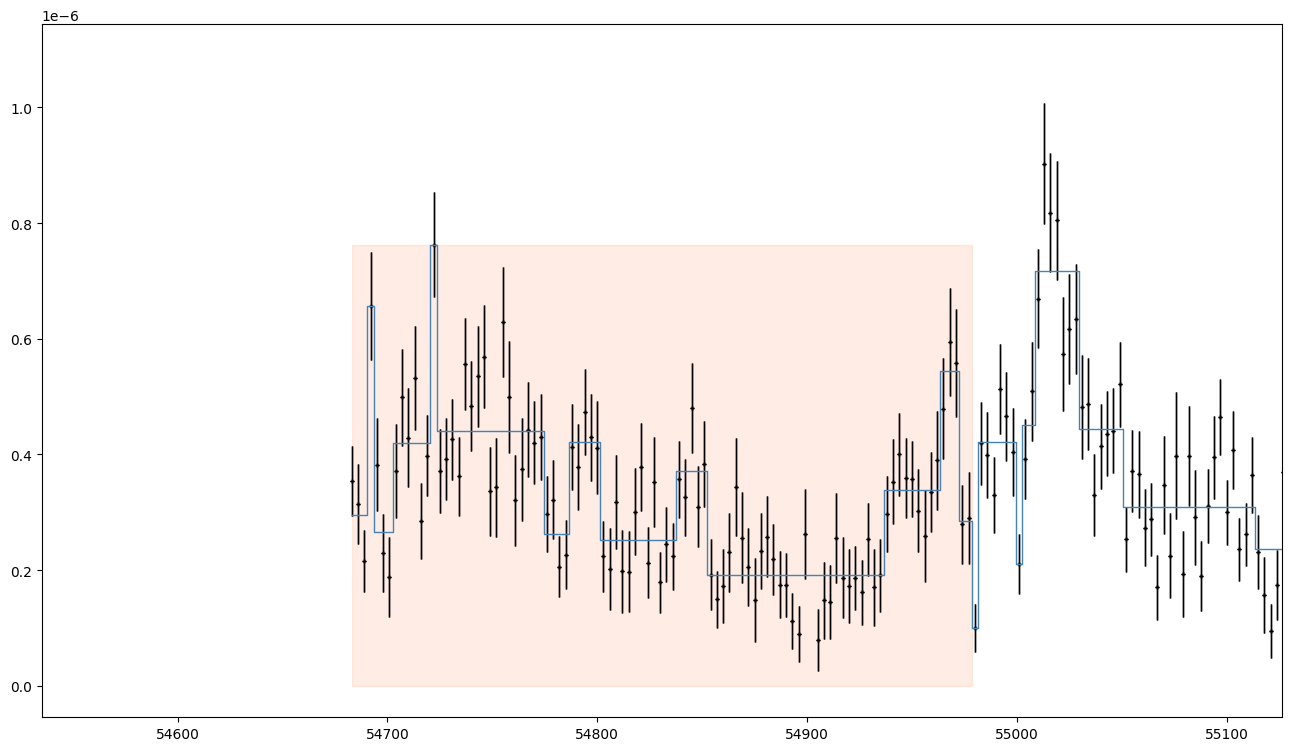

In [138]:
p = 0
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = 1
percent = 0.1
Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][p]
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


In [139]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3.  1.  3.  6.  1. 17.  4.  5. 12.  5. 27.  9.  3.  2.  1.  6.  1.  2.
  7.  7. 21.  9.  9. 22. 11. 23. 22. 31. 27. 50. 30.  8.  2. 25.  1.  8.
 21. 42.  7. 14. 22. 12.  1. 13.  5. 59.  1. 61. 50.  8.  5. 29. 30.  3.
 32. 45.  3.  6.  2. 22. 22. 47. 62.  1. 19. 16.  1.  1.  2.  5. 11.  4.
  6.  1.  5.  2.  1.  7. 19.  1.  9.  1.  4.  5.  8.  4. 10.  4.  2.  5.
 21.  5. 11. 24.  3.  1. 19. 26. 26.  5. 14.  5. 12. 10. 12.  1. 26. 16.
  2. 12.  7.  8. 26.  2. 10. 12. 28. 19.]


In [140]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54684.50001157, 54687.50001157, 54690.50001157, 54693.50001157,
       54696.50001157, 54699.50001157, 54702.50001157, 54705.50001157,
       54708.50001157, 54711.50001157, 54714.50001157, 54717.50001157,
       54720.50001157, 54723.50001157, 54726.50001157, 54729.50001157,
       54732.50001157, 54735.50001157, 54738.50001157, 54741.50001157,
       54744.50001157, 54747.50001157, 54750.50001157, 54753.50001157,
       54756.50001157, 54759.50001157, 54762.50001157, 54765.50001157,
       54768.50001157, 54771.50001157, 54774.50001157, 54777.50001157,
       54780.50001157, 54783.50001157, 54786.50001157, 54789.50001157,
       54792.50001157, 54795.50001157, 54798.50001157, 54801.50001157,
       54804.50001157, 54807.50001157, 54810.50001157, 54813.50001157,
       54816.50001157, 54819.50001157, 54822.50001157, 54825.50001157,
       54828.50001157, 54831.50001157, 54834.50001157, 54837.50001157,
       54840.50001157, 54843.50001157, 54846.50001157, 54849.50001157,
      

## Weekly

In [2]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'weekly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [381]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400
COSI_bkg_rate = 0.1


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')

        

    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=1,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=-(np.max(sourcelightcurve.flux)*0.01),y2=0,color='y',alpha=0.3,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    fsrq_names = select_fsrq()['Source_Name']
    bll_names = select_bll()['Source_Name']
    bcu_names = select_bcu()['Source_Name']
    flarestack=[0,0,0,0,0,0,0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        starttime_MJD= hops_bl[i].start_time
        starttime_s = starttime_MJD * 86400
        observation_time = (np.max(sourcelightcurve.time)-np.min(sourcelightcurve.time))*86400
        portion_of_obs = duration/observation_time
        integral = np.sum(temp_sum)
        background_counts = COSI_bkg_rate * duration
        fluxsum = np.sum(temp)
        if len(fsrq_names[fsrq_names==sourcelightcurve.name])>0:
            blazartype='FSRQ'
        elif len(bll_names[bll_names==sourcelightcurve.name])>0:
            blazartype='BLL'
        elif len(bcu_names[bcu_names==sourcelightcurve.name])>0:
            blazartype='BCU'
        else:
            blazartype='None'
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,fluxsum,integral,duration,background_counts,starttime_s,starttime_MJD,portion_of_obs,blazartype]))
    return flarestack

def ComputeMDP99(src_counts, bkg_counts, average_mu=0.3):
    
    mdp99 = 4.29 / average_mu * np.sqrt(src_counts+bkg_counts)/(src_counts) * 100
    
    return mdp99

Quiescent Background: 7.893394088669952e-08, Error: 2.5702845037690407e-09


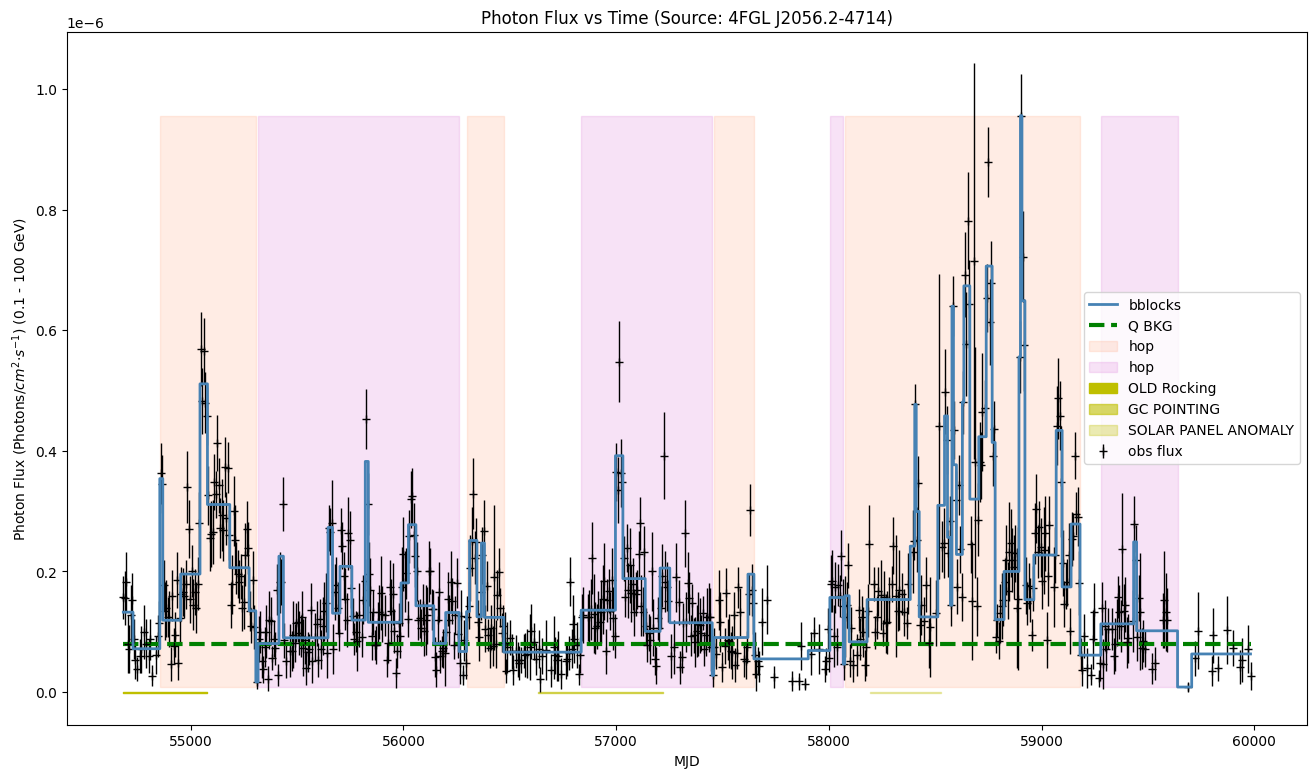

In [382]:
quiescent_flare_plot(cadence_df,sourcename='4FGL J2056.2-4714')

In [383]:

table = 'COSI_LAT_only_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0,0,0,0,0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean_COSI(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]
    #
    #if sourcename == '4FGL J1036.3-5833e':
    #    continue
    #if sourcename == '4FGL J1855.9+0121e':
    #    continue
    #if sourcename == '4FGL J1923.2+1408e':
    #    continue

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    quiescent_background,qui_err = quiescent_background_finder(sourcelightcurve=sourcelightcurve,method='forward')
    #sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)
    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,2].astype(float)*factor*Aeff
        flareflux = flarestack[:,1].astype(float)*factor
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,3]
        background_counts = flarestack[:,4]
        starttime_s = flarestack[:,5]
        starttime_mjd = flarestack[:,6]
        fraction_time = flarestack[:,7]
        blazartype = flarestack[:,8]

        COSI_BAND = np.array([flarenames,flareflux,flareintegrals,flareduration,background_counts,starttime_s,starttime_mjd,fraction_time,blazartype]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_BAT_weekly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_BAT_weekly_df.columns=['Name','Photon Flux (ph/cm2/s)','Photon Count','Duration (s)','Background Counts','Start Time (s)','Start Time (MJD)','Fraction of Observation Time','Class']

COSI_BAND_BAT_weekly_df


0
8.94e-07 2.18e-09 8.9182e-07 8.918200000000001e-08 9.136200000000001e-08
No flares detected initially, quiescent background is all bins
<class 'list'>
-----------------------------
Selecting FSRQ type blazars
Total number of variable objects: 572
-----------------------------
Selecting BL Lac type blazars
Total number of variable objects: 477
-----------------------------
Selecting unknown type blazars
Total number of variable objects: 364
 
[['0' '0' '0' '0' '0' '0' '0' '0' '0']
 ['4FGL J0001.5+2113' '3.14e-07' '0.1899072' '2721600.0' '272160.0'
  '4904539201.0' '56765.50001157408' '0.006072874493927126' 'FSRQ']
 ['4FGL J0001.5+2113' '1.61e-07' '0.0973728' '1209600.0' '120960.0'
  '4908772801.0' '56814.50001157408' '0.002699055330634278' 'FSRQ']
 ['4FGL J0001.5+2113' '2.8699999999999996e-07' '0.1735776' '9676800.0'
  '967680.0' '4913611201.0' '56870.50001157408' '0.021592442645074223'
  'FSRQ']
 ['4FGL J0001.5+2113' '1.66e-07' '0.10039680000000001' '3326400.0'
  '332640.0' '49489920

Name  Photon Flux (ph/cm2/s)            Photon Count  \
0                     0                       0                       0   
1                     0                     0.0                     0.0   
2     4FGL J0001.5+2113  1.7838799121071225e-07       7.704110190413403   
3     4FGL J0001.5+2113    9.14664540921168e-08        3.95019662629477   
4     4FGL J0001.5+2113  1.6304889642507775e-07       7.041654855568939   
...                 ...                     ...                     ...   
4606  4FGL J2348.0-1630  1.8726943144396889e-06       88.34970140331991   
4607                  0                     0.0                     0.0   
4608  4FGL J2348.1-4934  1.7319572504241185e-11  0.00044768223282413305   
4609                  0                     0.0                     0.0   
4610  4FGL J2358.3-1021  1.1296162343731723e-07      4.8161640998995825   

     Duration (s) Background Counts Start Time (s)   Start Time (MJD)  \
0               0                 0              0                  0   
1               0                 0              0                  0   
2       2721600.0          272160.0   4904539201.0  56765.50001157408   
3       1209600.0          120960.0   4908772801.0  56814.50001157408   
4       9676800.0          967680.0   4913611201.0  56870.50001157408   
...           ...               ...            ...                ...   
4606    7862400.0          786240.0   5164603201.0  59775.50001157408   
4607            0                 0              0                  0   
4608  251596800.0        25159680.0   4768459201.0  55190.50001157408   
4609            0                 0              0                  0   
4610    2721600.0          272160.0   5042131201.0  58358.00001157408   

     Fraction of Observation Time Class  
0                               0     0  
1                               0     0  
2            0.006072874493927126  FSRQ  
3            0.002699055330634278  FSRQ  
4            0.021592442645074223  FSRQ  
...                           ...   ...  
4606         0.017173051519154558  FSRQ  
4607                            0     0  
4608            0.574585635359116   BCU  
4609                            0     0  
4610         0.005936675461741424  FSRQ  

[4611 rows x 9 columns]

In [403]:
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!='0'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df = COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
COSI_BAND_BAT_weekly_df['Photon Count']= COSI_BAND_BAT_weekly_df['Photon Count'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (s)'] = COSI_BAND_BAT_weekly_df['Duration (s)'].astype(float)
COSI_BAND_BAT_weekly_df['Duration (weeks)'] = COSI_BAND_BAT_weekly_df['Duration (s)']/(86400*7)
COSI_BAND_BAT_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_BAT_weekly_df['Photon Count'].astype(float),COSI_BAND_BAT_weekly_df['Background Counts'].astype(float))
COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_BAT_weekly_df['Duration (s)']
COSI_BAND_BAT_weekly_df['Fraction of Observation Time'] = COSI_BAND_BAT_weekly_df['Fraction of Observation Time'].astype(float)



pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']=='4FGL J2253.9+1609']
neworder = ['Name','Class','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)','Fraction of Observation Time', 'MDP99','Start Time (MJD)', 'Start Time (s)']
#pd.set_option('display.max_rows',None)
COSI_BAND_BAT_weekly_df[neworder]
COSI_BAND_BAT_weekly_df[neworder]
COSI_BAND_BAT_weekly_df[neworder].to_csv('COSI_BAND_ALL_weekly_RbkgUpdated%.2f.csv'%COSI_bkg_rate)
COSI_BAND_BAT_weekly_df[neworder].sort_values('MDP99',ascending=True)


Name Class  Photon Flux (ph/cm2/s)  Fluence (ph/cm2)  \
3426   4FGL J2256.0-2740  FSRQ            3.916746e-04      3.055814e+04   
3264   4FGL J2143.5+1743  FSRQ            1.309347e-04      3.246762e+03   
3259   4FGL J2143.5+1743  FSRQ            9.966366e-05      1.446638e+03   
964   4FGL J0534.5+2201s  None            8.696629e-05      4.733749e+02   
3261   4FGL J2143.5+1743  FSRQ            5.904923e-05      5.356946e+02   
...                  ...   ...                     ...               ...   
3329   4FGL J2217.5+6346  None            4.002993e-13      4.745180e-05   
3247   4FGL J2142.8+1958   BCU            1.433136e-13      1.183129e-05   
3246   4FGL J2142.8+1958   BCU            1.012846e-13      7.167063e-06   
394    4FGL J0221.5+2513  FSRQ            1.393384e-13      2.439670e-05   
2795   4FGL J1759.1-3849   BCU            1.251079e-14      8.323178e-08   

      Photon Count Background Counts  Duration (s)  Duration (weeks)  \
3426  1.994954e+04         7801920.0    78019200.0             129.0   
3264  6.670022e+03         2479680.0    24796800.0              41.0   
3259  5.077024e+03         1451520.0    14515200.0              24.0   
964   2.705623e+03          544320.0     5443200.0               9.0   
3261  3.008061e+03          907200.0     9072000.0              15.0   
...            ...               ...           ...               ...   
3329  1.018247e-05        11854080.0   118540800.0             196.0   
3247  3.722556e-06         8255520.0    82555200.0             136.5   
3246  2.630858e-06         7076160.0    70761600.0             117.0   
394   3.571143e-06        17508960.0   175089600.0             289.5   
2795  3.056483e-07          665280.0     6652800.0              11.0   

      Fraction of Observation Time         MDP99   Start Time (MJD)  \
3426                      0.170861  2.004742e+02  59086.00001157408   
3264                      0.054377  3.380570e+02  57129.50001157408   
3259                      0.031830  3.399355e+02  56380.50001157408   
964                       0.011873  3.909062e+02  59726.50001157408   
3261                      0.019894  4.535443e+02  56772.50001157408   
...                            ...           ...                ...   
3329                      0.264507  4.835228e+11  56499.50001157408   
3247                      0.196403  1.103740e+12  56576.50001157408   
3246                      0.168345  1.445898e+12  55551.00001157408   
394                       0.399310  1.675556e+12  57385.00001157408   
2795                      0.015089  3.816070e+12  55771.50001157408   

     Start Time (s)  
3426   5105030401.0  
3264   4935988801.0  
3259   4871275201.0  
964    5160369601.0  
3261   4905144001.0  
...             ...  
3329   4881556801.0  
3247   4888209601.0  
3246   4799606401.0  
394    4958064001.0  
2795   4818657601.0  

[3571 rows x 12 columns]

In [404]:
COSI_BAND_ALL_weekly_df = COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df[:]['Photon Count']!='0'].reset_index(drop=True)
COSI_BAND_ALL_weekly_df = COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df[:]['Photon Count']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_weekly_df['Photon Count']= COSI_BAND_ALL_weekly_df['Photon Count'].astype(float)
COSI_BAND_ALL_weekly_df['Duration (s)'] = COSI_BAND_ALL_weekly_df['Duration (s)'].astype(float)
COSI_BAND_ALL_weekly_df['Duration (weeks)'] = COSI_BAND_ALL_weekly_df['Duration (s)']/(86400*7)
COSI_BAND_ALL_weekly_df['MDP99'] = ComputeMDP99(COSI_BAND_ALL_weekly_df['Photon Count'].astype(float),COSI_BAND_ALL_weekly_df['Background Counts'].astype(float))
COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'] = COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'].astype(float)
COSI_BAND_ALL_weekly_df['Fluence (ph/cm2)'] = COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'] * COSI_BAND_ALL_weekly_df['Duration (s)']



pd.reset_option('display.max_rows')
#pd.reset_option('display.max_columns')
COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df['Name']=='4FGL J2253.9+1609']
neworder = ['Name','Class','Photon Flux (ph/cm2/s)','Fluence (ph/cm2)','Photon Count','Background Counts','Duration (s)','Duration (weeks)', 'MDP99','Start Time (MJD)', 'Start Time (s)']
#pd.set_option('display.max_rows',None)
COSI_BAND_ALL_weekly_df[neworder]
COSI_BAND_ALL_weekly_df[neworder]
COSI_BAND_ALL_weekly_df[neworder].to_csv('COSI_BAND_ALL_weekly_RbkgUpdated%.2f.csv'%COSI_bkg_rate)
COSI_BAND_ALL_weekly_df[neworder].sort_values('MDP99',ascending=True)


Name Class  Photon Flux (ph/cm2/s)  Fluence (ph/cm2)  \
331  4FGL J0324.8+3412  None            9.440890e-03      1.712955e+05   
330  4FGL J0324.8+3412  None            1.123385e-02      5.197587e+05   
267  4FGL J1044.6+8053  FSRQ            1.172816e-02      7.660644e+05   
329  4FGL J0324.8+3412  None            1.195044e-02      9.576602e+05   
268  4FGL J1044.6+8053  FSRQ            1.343986e-02      1.637878e+06   
..                 ...   ...                     ...               ...   
4    4FGL J0538.8-4405   BLL            5.340248e-10      1.857125e-02   
1    4FGL J0538.8-4405   BLL            1.767891e-10      1.710753e-03   
7    4FGL J0538.8-4405   BLL            7.567921e-11      3.203955e-04   
6    4FGL J0538.8-4405   BLL            7.454938e-11      3.606997e-04   
3    4FGL J0538.8-4405   BLL            6.913004e-11      2.926690e-04   

      Photon Count Background Counts  Duration (s)  Duration (weeks)  \
331  486922.247484          181440.0    18144000.0              30.0   
330  579395.655113          462672.0    46267200.0              76.5   
267  603021.273761          653184.0    65318400.0             108.0   
329  616354.365206          801360.0    80136000.0             132.5   
268  691031.076727         1218672.0   121867200.0             201.5   
..             ...               ...           ...               ...   
4         0.021399          347760.0    34776000.0              57.5   
1         0.007084           96768.0     9676800.0              16.0   
7         0.003033           42336.0     4233600.0               7.0   
6         0.002987           48384.0     4838400.0               8.0   
3         0.002770           42336.0     4233600.0               7.0   

            MDP99   Start Time (MJD) Start Time (s)  
331  2.400946e+00  56464.50001157408   4878532801.0  
330  2.519468e+00  55803.00001157408   4821379201.0  
267  2.657870e+00  55897.50001157408   4829544001.0  
329  2.762485e+00  54774.00001157408   4732473601.0  
268  2.859706e+00  56870.50001157408   4913611201.0  
..            ...                ...            ...  
4    3.940710e+07  57500.50001157408   4968043201.0  
1    6.279233e+07  56415.50001157408   4874299201.0  
7    9.702295e+07  59271.50001157408   5121057601.0  
6    1.052938e+08  59194.50001157408   5114404801.0  
3    1.062146e+08  57444.50001157408   4963204801.0  

[468 rows x 11 columns]

Text(0, 0.5, 'Number of Sources')

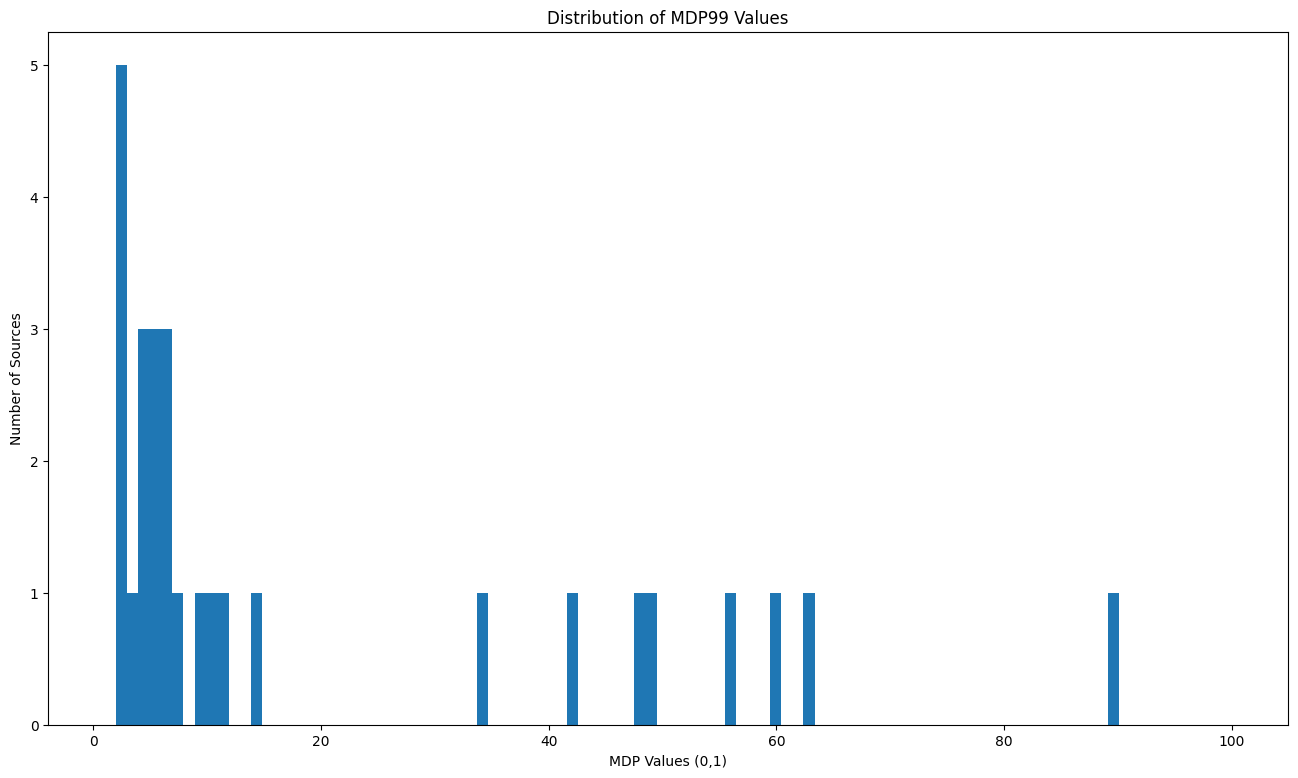

In [331]:
#COSI_BAND_ALL_weekly_df.to_csv('COSI_BAND_ALL_weekly_0bkg.csv')
plt.figure(figsize=(16,9))
plt.hist(COSI_BAND_ALL_weekly_df['MDP99'],bins=100,range=(1,100))
plt.title('Distribution of MDP99 Values')
plt.xlabel('MDP Values (0,1)')
plt.ylabel('Number of Sources')

Text(0, 0.5, 'MDP$_{99}$ [%]')

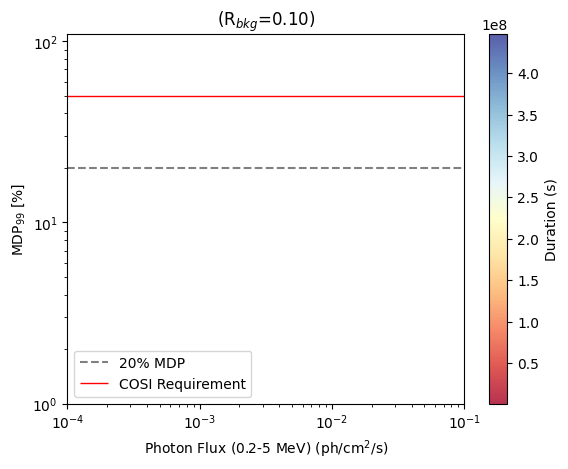

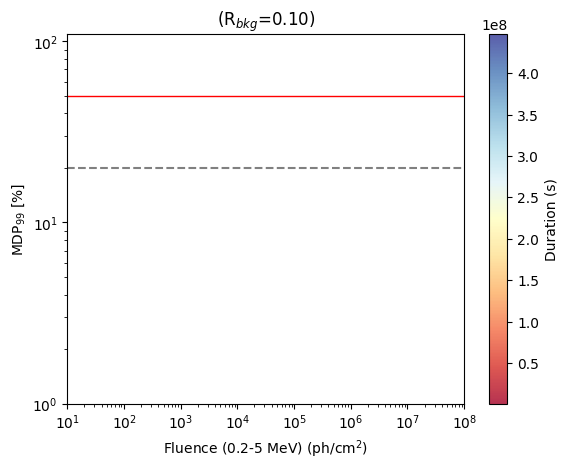

In [406]:
#plt.scatter(COSI_BAND_ALL_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_ALL_weekly_df['MDP99'])
plt.figure()
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_BAT_weekly_df['Duration (s)']
sc = plt.scatter(COSI_BAND_BAT_weekly_df['Photon Flux (ph/cm2/s)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (s)']*1e-5, cmap=cm,alpha = 0.8,edgecolors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Duration (s)')
plt.ylim(1,110)
plt.xlim(1e-4,1e-1)
plt.hlines(20,1e-4,1e-1,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,1e-4,1e-1,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.ylabel(r'MDP$_{99}$ [%]')
plt.title(r'(R$_{bkg}$=%.2f)'%COSI_bkg_rate)
plt.legend(loc=3)
#plt.savefig('Diagrams/COSI_Flux_v_MDP99_Rbkg%.2f.png'%COSI_bkg_rate, dpi=200)


plt.figure()
cm = plt.get_cmap('RdYlBu')
z = COSI_BAND_BAT_weekly_df['Duration (s)']
sc = plt.scatter(COSI_BAND_BAT_weekly_df['Fluence (ph/cm2)'],COSI_BAND_BAT_weekly_df['MDP99'],c=z, s=COSI_BAND_BAT_weekly_df['Duration (s)']*1e-5, cmap=cm, alpha =0.8,edgecolors='k')
cbar = plt.colorbar(sc)
cbar.set_label('Duration (s)')
plt.hlines(20,10,1e+8,colors='0.5',linestyles='dashed',label='20% MDP')
plt.hlines(50,10,1e+8,colors = 'r',lw=1,label = 'COSI Requirement')
plt.xscale('log')
plt.yscale('log')
plt.title(r'(R$_{bkg}$=%.2f)'%COSI_bkg_rate)
plt.ylim(1,110)
plt.xlim(10,1e+8)
plt.xlabel(r'Fluence (0.2-5 MeV) (ph/cm$^2$)')
plt.ylabel(r'MDP$_{99}$ [%]')
#plt.savefig('Diagrams/COSI_Fluence_v_MDP99_Rbkg%.2f.png'%COSI_bkg_rate, dpi=200)

In [ ]:
COSI_LAT_Sources[COSI_LAT_Sources['Name']='4FGL J2253.9+1609'

Name  ph/s_ratio  Aeff_mean(cm2)
0   4FGL J2253.9+1609    0.343804     5449.182919
1   4FGL J2253.9+1609    1.202340     5913.637940
2   4FGL J2253.9+1609    0.426944     5964.610300
3   4FGL J2253.9+1609    0.000527     6993.495144
4   4FGL J2253.9+1609    0.009530     6523.682940
..                ...         ...             ...
60  4FGL J2253.9+1609    1.820678     5533.541922
61  4FGL J2253.9+1609    0.514739     5460.844580
62  4FGL J2253.9+1609    8.482368     5195.910851
63  4FGL J2253.9+1609    0.298478     5247.438973
64  4FGL J2253.9+1609    0.116632     5587.343040

[65 rows x 3 columns]

4FGL J2253.9+1609


<Figure size 1600x900 with 0 Axes>

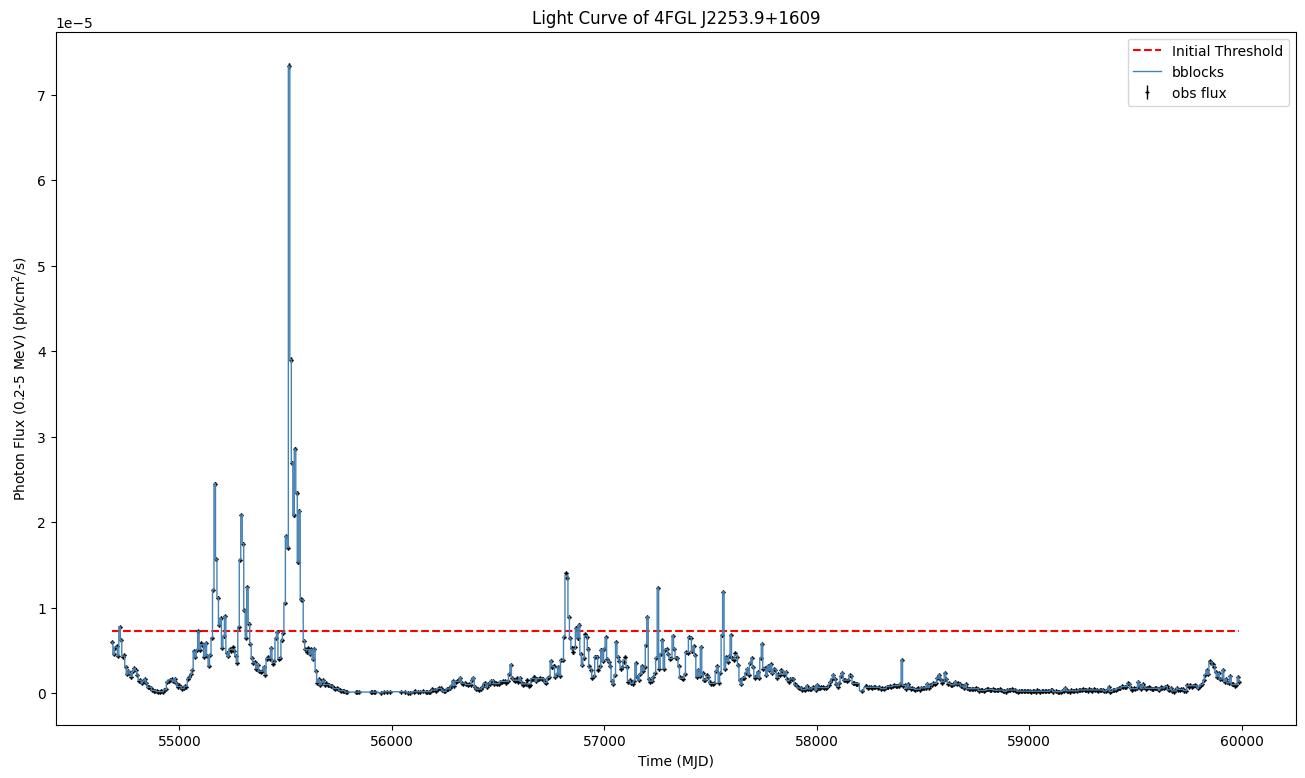

<Figure size 1600x900 with 0 Axes>

In [387]:
p = 2
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = COSI_LAT_Sources['ph/s_ratio'][p]
percent = 0.1
Aeff = 70
sourcename = '4FGL J2253.9+1609'
print(sourcename)
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring = sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)


time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
plt.hlines(thresholdflux,xmin=np.min(sourcelightcurve.time),xmax=np.max(sourcelightcurve.time),label='Initial Threshold',colors='red',linestyles='dashed')
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
#sourcelightcurve.plot_hop()
plt.title('Light Curve of ' +str(titlestring))
plt.ylabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.xlabel('Time (MJD)')
plt.legend()

plt.figure(figsize=(16,9))
#hops_bl = sourcelightcurve.hops
#hops_bl[0].plot_hop()


In [155]:
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
sourcearray
observation_time = np.max(sourcearray['tmax'])-np.min(sourcearray['tmin'])
print(observation_time)

459648000


Quiescent Background: 1.303719649122807e-06, Error: 6.229317736250665e-09


/var/folders/td/mm4slxv90412jt0yh0zz6zgw0000gp/T/ipykernel_66983/1194800148.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


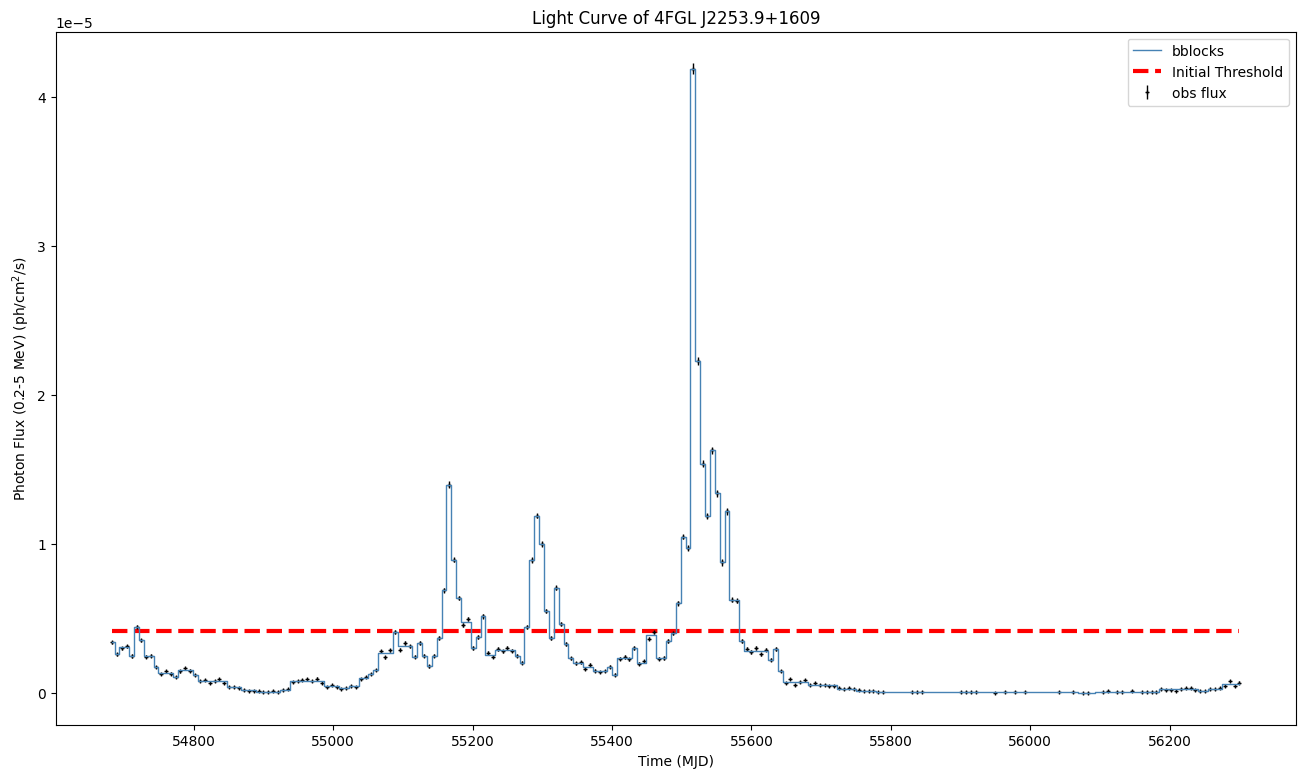

In [388]:

percent = 0.1 
MJDREFI=51910 
MJDREFF=7.428703703703703e-4
bkg_err = True 
factor = 1
# Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.




sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring = sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
sourcearray = sourcearray[0:200]

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux = np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

#if sourcelightcurve.hops == None:
#    print("No flares detected for "+str(titlestring))
#    return None


# Finding quiescent background.
quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


# Using quiescent background to find flares again.
sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


#sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
sourcelightcurve.get_bblocks(gamma_value=0.05)
#sourcelightcurve.get_bblocks_above(threshold = 0)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)



# Plotting the Lightcurve itself.
plt.figure(figsize=(16,9))
plt.title('Light Curve of ' +str(titlestring))
plt.ylabel(r'Photon Flux (0.2-5 MeV) (ph/cm$^2$/s)')
plt.xlabel('Time (MJD)')
plt.legend()

sourcelightcurve.plot_bblocks(size=1)
sourcelightcurve.plot_hline(value = thresholdflux, color='red',label='Initial Threshold',lw=3,linestyle = 'dashed')

#if bkg_err == True:
#    y1 = quiescent_background + qui_err
#    y2 = quiescent_background - qui_err
#    plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

#sourcelightcurve.plot_hop()
#plotting_anomalies()
plt.legend()



In [ ]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3. 11.  1.  2.  8. 11.  4.  2.  1.  4.  3.  4.  8.  2.  7.  6.  7.  7.
  4.  8. 13. 12. 21. 12. 21.  8. 19.  3.  7. 10. 13.  2.  4. 16. 36. 23.
  4. 15. 14.  6. 27.  7.  1.  8. 44.  8.  8. 35. 13.  9.  1.  5.  1. 11.
  1.  4.  2.  3.  3.  2.  4.  5.  8.  3.  5. 10.  1.  1.  8. 13.  3.  8.
  3.  7.  2.  5. 21.  9.  3.  8. 16.  5. 12. 13.]


In [ ]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54686.50001157, 54693.50001157, 54700.50001157, 54707.50001157,
       54714.50001157, 54721.50001157, 54728.50001157, 54735.50001157,
       54742.50001157, 54749.50001157, 54756.50001157, 54763.50001157,
       54770.50001157, 54777.50001157, 54784.50001157, 54791.50001157,
       54798.50001157, 54805.50001157, 54812.50001157, 54819.50001157,
       54826.50001157, 54833.50001157, 54840.50001157, 54847.50001157,
       54854.50001157, 54861.50001157, 54868.50001157, 54875.50001157,
       54882.50001157, 54889.50001157, 54896.50001157, 54903.50001157,
       54910.50001157, 54917.50001157, 54924.50001157, 54931.50001157,
       54938.50001157, 54945.50001157, 54952.50001157, 54959.50001157,
       54966.50001157, 54973.50001157, 54980.50001157, 54987.50001157,
       54994.50001157, 55001.50001157, 55008.50001157, 55015.50001157,
       55022.50001157, 55029.50001157, 55036.50001157, 55043.50001157,
       55050.50001157, 55057.50001157, 55064.50001157, 55071.50001157,
      

In [332]:
dutycycle_arr=[0,0]
for i in range(0,len(COSI_BAND_ALL_weekly_df)):
    sourcename = COSI_BAND_ALL_weekly_df['Name'][i]
    flaringtime = np.sum([COSI_BAND_ALL_weekly_df[COSI_BAND_ALL_weekly_df['Name']==sourcename]['Duration (s)']])
    print(flaringtime)
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    timearray = sourcearray['tmin']/SecsInDay + MJDREFI
    obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
    print('obstime is',obstime)
    dutycycle = [sourcename,flaringtime/obstime]
    dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))



339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
339897600.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
425476800.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
447249600.0
obstime is 459043200.0
4233600.0
obstime is 459043200.0
440899200.0
obstime is 459043200.0
452390400.0
obstime is 459043200.0
417009600.0
obstime is

In [333]:
pd.DataFrame(dutycycle_arr).drop_duplicates(ignore_index=True)

0                    1
0                   0                    0
1   4FGL J0538.8-4405   0.7404479578392622
2   4FGL J1104.4+3812   0.9268774703557312
3   4FGL J1653.8+3945    0.974308300395257
4   4FGL J0136.5+3906  0.00922266139657444
..                ...                  ...
56  4FGL J0721.9+7120   0.8682476943346509
57  4FGL J2202.7+4216  0.38537549407114624
58  4FGL J2232.6+1143  0.09617918313570488
59  4FGL J1337.6-1257   0.9321475625823452
60  4FGL J0428.6-3756   0.6778656126482213

[61 rows x 2 columns]

In [389]:
dutycycle_arr=[0,0,0]
print(len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1)
for i in range(0,len(COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True))-1):
    sourcename = COSI_BAND_BAT_weekly_df['Name'].drop_duplicates(ignore_index=True)[i]
    if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class']))>0:
        blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Class'])[-1]
    else:
        blazartype = 'BCU'
    #print(blazartype)
    dutycyclevalue = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])
    print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename]['Fraction of Observation Time'])

    #print(flaringtime)
    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    #observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
    #obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
    #print('obstime is',obstime)
    dutycycle = [sourcename,dutycyclevalue,blazartype]
    dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))

745
0     0.006073
1     0.002699
2     0.021592
3     0.007422
4     0.008097
5     0.017544
6     0.003374
7     0.016869
8     0.009447
9     0.036437
10    0.005398
11    0.004723
Name: Fraction of Observation Time, dtype: float64
12    0.150492
Name: Fraction of Observation Time, dtype: float64
13    0.043536
Name: Fraction of Observation Time, dtype: float64
14    0.082447
15    0.033910
16    0.271277
Name: Fraction of Observation Time, dtype: float64
17    0.116909
18    0.081242
19    0.028402
20    0.182299
Name: Fraction of Observation Time, dtype: float64
21    0.108378
22    0.065824
23    0.301862
Name: Fraction of Observation Time, dtype: float64
24    0.020503
25    0.024471
26    0.017196
27    0.007275
28    0.012566
Name: Fraction of Observation Time, dtype: float64
29    0.316783
Name: Fraction of Observation Time, dtype: float64
30    0.017241
31    0.102665
32    0.210031
Name: Fraction of Observation Time, dtype: float64
33    0.029683
34    0.054749
35    0.0052

In [268]:
pd.DataFrame(dutycycle_arr)==1

0      1      2
0    False  False  False
1    False  False  False
2    False  False  False
3    False  False  False
4    False  False  False
..     ...    ...    ...
737  False  False  False
738  False  False  False
739  False  False  False
740  False  False  False
741  False  False  False

[742 rows x 3 columns]

In [335]:
truthmask = dutycycle_arr[:,1].astype('float64')==1
pd.DataFrame(dutycycle_arr[:,0][truthmask]).drop_duplicates(ignore_index=True)

Empty DataFrame
Columns: [0]
Index: []

In [272]:
errorarray = pd.DataFrame(dutycycle_arr[truthmask][:,0]).drop_duplicates(ignore_index=True)
print(errorarray[0][0])

4FGL J0003.3-1928


In [177]:
i=0
sourcename1 = COSI_BAND_BAT_weekly_df['Name'][i]
if len(np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Class']))>0:
    blazartype = np.array(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Class'])[-1]
else:
    blazartype = 'BCU'
#print(blazartype)
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Duration (s)']
flaringtime = np.sum(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Duration (s)'])
print(flaringtime)
#print(COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Duration (s)']/60/60/24)

#print(flaringtime)
sourcearray = cadence_df[cadence_df['source_name'] == sourcename1].reset_index(drop=True)
observation_time = np.max(sourcearray['tmin'])-np.min(sourcearray['tmin'])
#obstime = (np.max(timearray)-np.min(timearray))*SecsInDay
#print('obstime is',obstime)
dutycycle = [sourcename1,flaringtime/obstime,blazartype]
dutycycle_arr = np.vstack((dutycycle_arr,dutycycle))
dutycycle
COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==sourcename1]['Duration (s)']

232243200.0


0    49291200.0
1    83462400.0
2     1209600.0
3     9676800.0
4    23889600.0
5     1512000.0
6     7560000.0
7    46569600.0
8     9072000.0
Name: Duration (s), dtype: float64

4FGL J0047.0+5657
Quiescent Background: nan, Error: 3.87e-08


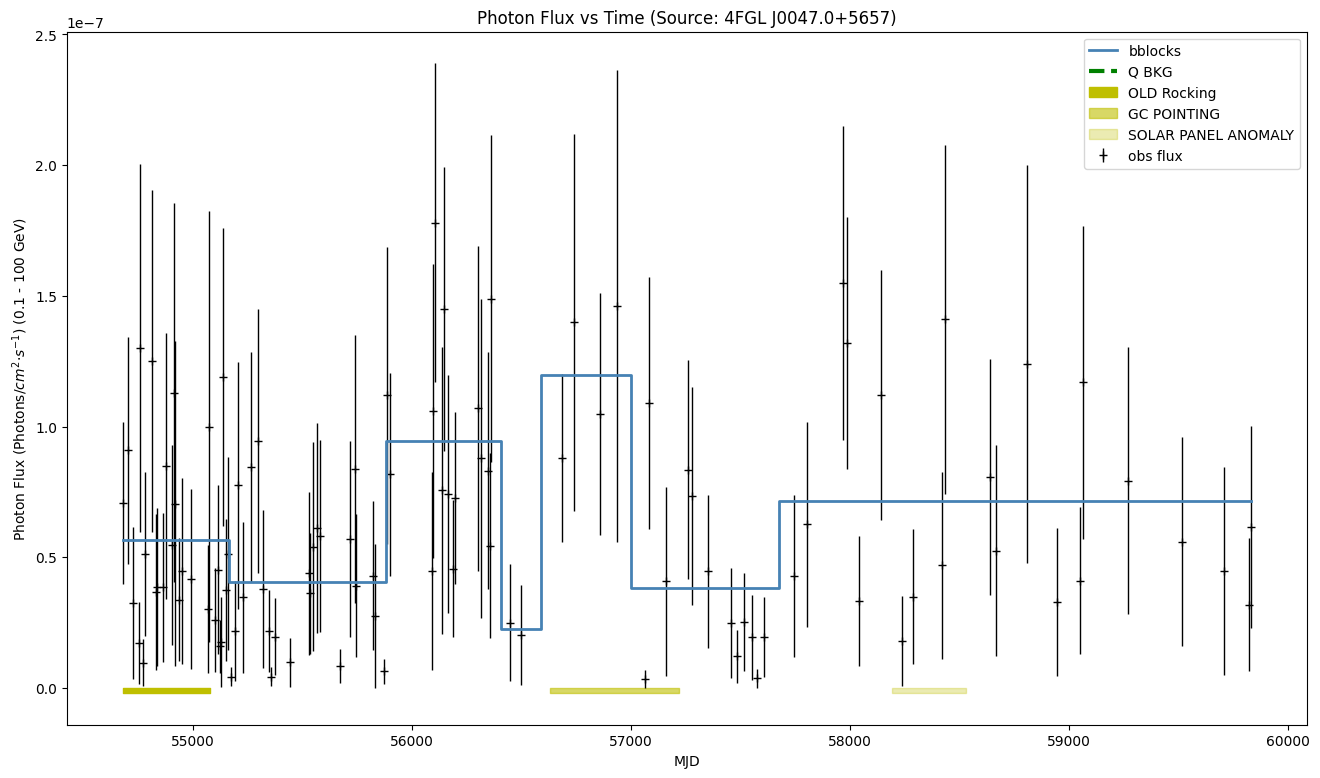

In [326]:
p = 2
jimjomes = errorarray[0][p]
print(jimjomes)
quiescent_flare_plot(sourcename = jimjomes,cadence_df=cadence_df)

#COSI_BAND_BAT_weekly_df[COSI_BAND_BAT_weekly_df['Name']==jimjomes]

In [391]:
filtereddutycycles = dutycycle_arr[dutycycle_arr[:,1]!='1.0']
pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True)

0                     1     2
0                    0                     0     0
1    4FGL J0555.6+3947  0.002663115845539281  FSRQ
2    4FGL J0055.1-1219  0.005319148936170213   BCU
3    4FGL J0354.7+8009   0.00728476821192053   BLL
4    4FGL J0617.2+5701  0.010652463382157125   BLL
..                 ...                   ...   ...
741  4FGL J1128.0+5924    0.8541383989145184  FSRQ
742  4FGL J2338.0-0230    0.8603723404255319  FSRQ
743  4FGL J0922.6+0434    0.8921438082556591   BCU
744  4FGL J1114.5-0819    0.9804469273743017  FSRQ
745  4FGL J0325.6-1646                 0.986   BLL

[746 rows x 3 columns]

Text(0.5, 0, 'Duty Cycle Ratio')

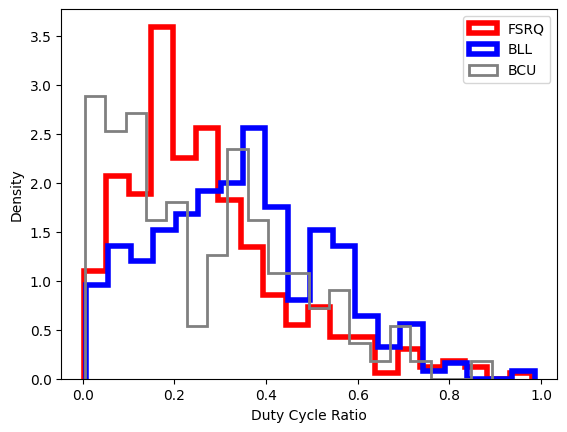

In [392]:
plt.figure()
plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)


plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)

plt.hist(x=filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
#plt.yscale('log')
#plt.xscale('log')

Text(0.5, 1.0, 'Duty Cycle Distribution of FSRQ and BLL Sources')

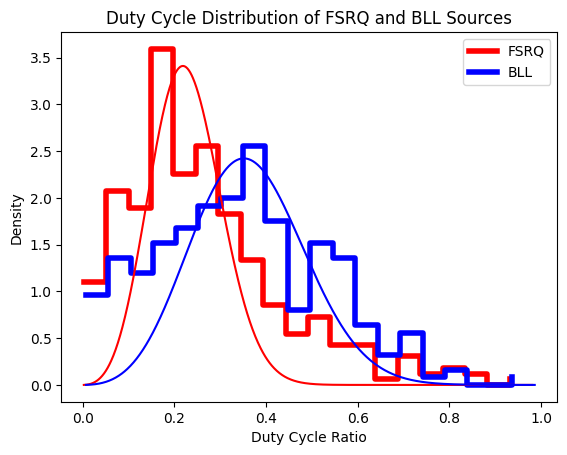

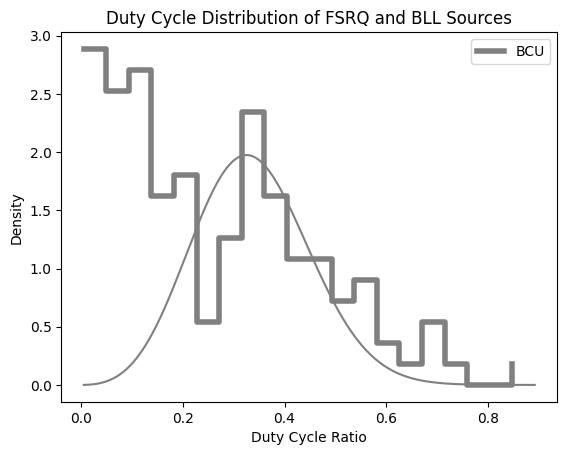

In [393]:

from scipy.optimize import curve_fit

def maxwellian_function(x, N, a):
    mu = 2*a*(np.sqrt(2/np.pi))
    return N * (x**2*np.exp(-(x - mu)**2/(2*a**2)))/a**3


y_fsrq,xe_fsrq=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float),bins=20,density=True)
x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
x_fsrq_refine = np.linspace(xe_fsrq[0],xe_fsrq[-1],1000)
y_bll,xe_bll=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float),bins=20,density=True)
x_bll = (xe_bll[:-1]+xe_bll[1:])/2
x_bll_refine = np.linspace(xe_bll[0],xe_bll[-1],1000)
y_bcu,xe_bcu=np.histogram(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float),bins=20,density=True)
x_bcu = (xe_bcu[:-1]+xe_bcu[1:])/2
x_bcu_refine = np.linspace(xe_bcu[0],xe_bcu[-1],1000)

maxfsrq=maxwellian_function(x_fsrq,0.1,a=0.1)
popt_fsrq, pcov_fsrq = curve_fit(maxwellian_function, x_fsrq, y_fsrq,p0=[0.1,0.1])
dipo_ampl_fitmaxwell = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
dipo_ampl_fitmaxwell_err = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)
maxfsrq = maxwellian_function(x_fsrq_refine,popt_fsrq[0],popt_fsrq[1])

maxbll=maxwellian_function(x_bll,0.1,a=0.1)
popt_bll, pcov_bll = curve_fit(maxwellian_function, x_bll, y_bll,p0=[0.1,0.1])
dipo_ampl_fitmaxwell = 2 * popt_bll[1] * np.sqrt(2 / np.pi)
dipo_ampl_fitmaxwell_err = np.sqrt((popt_bll[1]**2 * (3 * np.pi - 8)) / np.pi)
maxbll=maxwellian_function(x_bll_refine,popt_bll[0],popt_bll[1])

maxbcu=maxwellian_function(x_bcu,0.1,a=0.1)
popt_bcu, pcov_bcu = curve_fit(maxwellian_function, x_bcu, y_bcu,p0=[0.1,0.1])
dipo_ampl_fitmaxwell = 2 * popt_bcu[1] * np.sqrt(2 / np.pi)
dipo_ampl_fitmaxwell_err = np.sqrt((popt_bcu[1]**2 * (3 * np.pi - 8)) / np.pi)
maxbcu = maxwellian_function(x_bcu_refine,popt_bcu[0],popt_bcu[1])

plt.figure()
#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='FSRQ'][:,1].astype(float)),label='FSRQ',bins=20,density=True,histtype='step',color='r',linewidth=4)


#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BLL'][:,1].astype(float)),label='BLL',bins=20,density=True,histtype='step',color='blue',linewidth=4)

#plt.hist(x=np.log(filtereddutycycles[filtereddutycycles[:,2]=='BCU'][:,1].astype(float)),label='BCU',bins=20,density=True,histtype='step',color='grey',linewidth=2)
plt.step(xe_fsrq[:-1],y_fsrq,where='post',color='r',linewidth=4,label='FSRQ')
plt.step(xe_bll[:-1],y_bll,where='post',color='blue',linewidth=4,label='BLL')
#plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4)
plt.plot(x_fsrq_refine,maxfsrq,color='r')
plt.plot(x_bll_refine,maxbll,color='blue')
#plt.plot(x_bcu_refine,maxbcu,color='grey')

plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Distribution of FSRQ and BLL Sources')

plt.figure()
plt.step(xe_bcu[:-1],y_bcu,where='post',color='grey',linewidth=4,label='BCU')
plt.plot(x_bcu_refine,maxbcu,color='grey')
plt.legend()
plt.ylabel('Density')
plt.xlabel('Duty Cycle Ratio')
plt.title('Duty Cycle Distribution of FSRQ and BLL Sources')


In [351]:
from scipy.optimize import curve_fit




x_fsrq = (xe_fsrq[:-1]+xe_fsrq[1:])/2
popt_fsrq, pcov_fsrq = curve_fit(maxwellian_function, x_fsrq, y_fsrq)
dipo_ampl_fitmaxwell = 2 * popt_fsrq[1] * np.sqrt(2 / np.pi)
dipo_ampl_fitmaxwell_err = np.sqrt((popt_fsrq[1]**2 * (3 * np.pi - 8)) / np.pi)  
print('Dipole amplitude relative to monopole (fit maxwellian) = %.2e +- %.2e' %(dipo_ampl_fitmaxwell, dipo_ampl_fitmaxwell_err))

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

Quiescent Background: 9.464999999999999e-09, Error: 9.82784536123989e-09


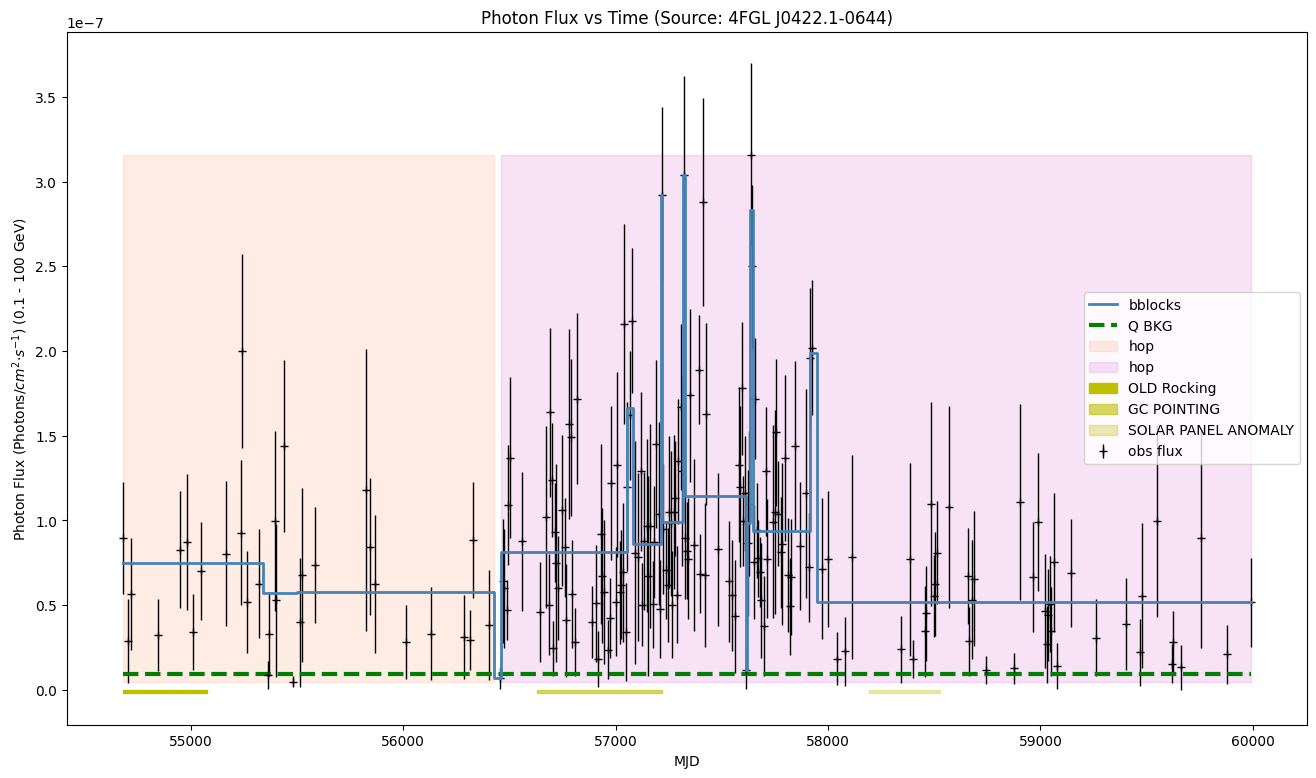

In [322]:
quiescent_flare_plot(sourcename = pd.DataFrame(filtereddutycycles).sort_values(by=1).reset_index(drop=True)[0][630],cadence_df=cadence_df)

In [128]:
dutycycle_df=pd.DataFrame(dutycycle_arr)
dutycycle_df.columns=['Name','Duty Cycle Ratio','Class']
dutycycle_df
dutycycle_df.to_csv('COSI_BAND_ALL_weekly_duty_cycles.csv')


## Monthly

In [106]:
table = "new_db_Feb2023.csv"
opened = open(table,"r")
readed = pd.read_csv(table, sep=",", na_filter=True)
readed = readed.fillna(-3333)

cadence = 'Monthly'
cadence_df = readed.loc[(readed['cadence'] == cadence) #& \
                        # (readed['ts2'] <= 4.) & \
                        # (readed['photon_flux_error2'] <  readed['photon_flux2'])
                        ]
#cadence_df.loc[cadence_df['ts2'] <= 9., 'photon_flux2'] = -3333
cadence_df.loc[cadence_df['ts2'] <= 4., ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set as -3333 all points with an error larger than the flux
cadence_df.loc[cadence_df['photon_flux_error2'] > cadence_df['photon_flux2'], ['photon_flux2', 'photon_flux_error2']] = -3333
#Jorge: Set cuts to remove possible outliers due to bad convergence of a bin
cadence_df.loc[cadence_df['photon_flux2'] > 1e-4, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[cadence_df['photon_flux2'] < 1e-10, ['photon_flux2', 'photon_flux_error2']] = -3333
cadence_df.loc[(cadence_df['ts2']<=25) & (cadence_df['photon_flux2'] > 1e-6)] = -3333
#print(cadence_df)
cadence_df = cadence_df.reset_index(drop=True)
TSTART = np.amin(cadence_df['tmin'])
TSTOP = np.amax(cadence_df['tmax'])

names = np.unique(readed['source_name']) #.drop_duplicates(subset=['source_name'], inplace=False)#[1]

df_4lacdr3 = pd.read_csv('4lac_redshifts.csv', delimiter='\t', comment='#')

In [107]:
# Writing the python file here until I'm sure I can export it and be correct.

MJDREFI = 51910
MJDREFF = 7.428703703703703e-4
SecsInDay = 86400


def MET_to_MJD(MET,MJDREF=51910):
    return MET/86400 + MJDREF


def quiescent_background_finder(sourcelightcurve, method='forward'):
    # Determines the "quiescent background" of a given lightcurve
    qui = sourcelightcurve
    
    if not hasattr(sourcelightcurve, "hops") or sourcelightcurve.hops is None:
        quiescent_background = np.nanmean(qui.flux)
        qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2))
        print('No flares detected initially, quiescent background is all bins')
        return quiescent_background, qui_err

    # Mask out flaring regions
    mask = []
    for hop in sourcelightcurve.hops:
        start_idx = np.searchsorted(sourcelightcurve.time, hop.start_time)
        end_idx = np.searchsorted(sourcelightcurve.time, hop.end_time)
        if start_idx < end_idx:
            mask.extend(range(start_idx, end_idx))

    maskindices = np.array(mask)
    
    # Avoid deleting empty list.
    if maskindices.size > 0:
        qui.flux = np.delete(qui.flux, maskindices)
        qui.time = np.delete(qui.time, maskindices)
        qui.flux_error = np.delete(qui.flux_error, maskindices)

    if qui.flux.size == 0:
        print("All time bins were flaring. No quiescent background can be determined.")
        return np.nan, np.nan

    # Compute weighted average of non-flaring sections
    baseaverage = []
    weights = []
    tempavg = []

    if cadence_df['cadence'][0] == 'daily':
        tdiff = 3
    if cadence_df['cadence'][0] == 'weekly':
        tdiff = 7
    if cadence_df['cadence'][0] == 'monthly':
        tdiff = 30


    for i in range(len(qui.flux) - 1):
        tempavg.append(qui.flux[i])

        # Check for time gap or last element
        if i == len(qui.flux) - 2 or (qui.time[i + 1] - qui.time[i] != tdiff):
            if tempavg:
                baseaverage.append(np.nanmean(tempavg))
                weights.append(len(tempavg))
            tempavg = []

    # Computing Weighted Mean, putting failsafes to avoid empty averages.
    if baseaverage and weights:
        quiescent_background = np.average(baseaverage, weights=weights)
    else:
        quiescent_background = np.nan

    qui_err = np.sqrt(np.sum((np.array(qui.flux_error) ** 2) * (1 / len(qui.flux_error)) ** 2)) if len(qui.flux_error) > 0 else 0

    print(f"Quiescent Background: {quiescent_background}, Error: {qui_err}")
    return quiescent_background, qui_err



def LCTimeRange(sourcearray, timerangestart,timerangeend):
    sourcearray = sourcearray[timerangestart:timerangeend]
    return sourcearray

def quiescent_flare_plot(cadence_df,sourcename=None,sourcenum=0,percent = 0.1, MJDREFI=51910, MJDREFF=7.428703703703703e-4,bkg_err = False, factor = 1):
    # Depending on what we are doing analysis on/how our time is binned, we can change the MJDREFI to other values.
    


    if sourcename == None:
        sourcearray = cadence_df[cadence_df['source_name'] == cadence_df['source_name'][sourcenum]]
        titlestring=cadence_df['source_name'][sourcenum]
    else:
        sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
        titlestring=sourcename


    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)
    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2'] * factor
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux =np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent


    # Finding first set of flares using threshold flux.
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    #if sourcelightcurve.hops == None:
    #    print("No flares detected for "+str(titlestring))
    #    return None


    # Finding quiescent background.
    quiescent_background, qui_err = quiescent_background_finder(sourcelightcurve,'forward')


    # Using quiescent background to find flares again.
    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd')


    #sourcelightcurve.flux = np.subtract(sourcelightcurve.flux,quiescent_background)
    sourcelightcurve.get_bblocks(gamma_value=0.05)
    #sourcelightcurve.get_bblocks_above(threshold = 0)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add',baseline = quiescent_background)


    
    # Plotting the Lightcurve itself.
    plt.figure(figsize=(16,9))
    plt.xlabel("MJD")
    plt.ylabel('Photon Flux (Photons/$cm^2\u22c5s^{-1}$) (0.1 - 100 GeV)')
    plt.title("Photon Flux vs Time" ' (Source: ' +str(titlestring)+ ')' )
    sourcelightcurve.plot_bblocks(size=2)
    sourcelightcurve.plot_hline(value = quiescent_background, color='green',label='Q BKG',lw=3,linestyle = 'dashed')

    if bkg_err == True:
        y1 = quiescent_background + qui_err
        y2 = quiescent_background - qui_err
        plt.fill_between(sourcelightcurve.time,y1,y2,alpha = 0.3,color='green',label = 'Q BKG Error')

    sourcelightcurve.plot_hop()
    plotting_anomalies()
    plt.legend()

def plotting_anomalies():
    ROCKING_pre50_START   = MET_to_MJD(239557417.000)
    ROCKING_50_START      = MET_to_MJD(273628802.000)

    GC_START              = MET_to_MJD(407898663.000)  
    GC_STOP               = MET_to_MJD(458755204.000)   

    ANOMALY_MET           = MET_to_MJD(542851205.000) 
    START_NEW_PROFILE     = MET_to_MJD(571795205.000) 

    #plt.axvspan((ROCKING_pre50_START), (ROCKING_50_START),
        #color='y', alpha=0.6, label='OLD ROCKING')
    plt.fill_between([ROCKING_pre50_START,ROCKING_50_START],y1=0,y2=1e-8,color='y',alpha=0.6,label='OLD Rocking')
    plt.fill_between([GC_START,GC_STOP],y1=0,y2=1e-8,color='y',alpha=0.6,label='GC POINTING')
    plt.fill_between([ANOMALY_MET,START_NEW_PROFILE],y1=0,y2=1e-8,color='y',alpha=0.6,label='SOLAR PANEL ANOMALY')

    #plt.axvspan((GC_START),
    #    (GC_STOP),
    #    color='y', alpha=0.40, label='GC POINTING')
    #plt.axvspan((ANOMALY_MET),(START_NEW_PROFILE),
    #    color='y', alpha=0.2, label='SOLAR PANEL ANOMALY')

def fluence_integrator(hops_bl,sourcelightcurve, time = 's',):
    flarestack=[0,0,0]
    for i in range(0,len(hops_bl)):
        temp = sourcelightcurve.flux[np.min(hops_bl[i].iis):np.max(hops_bl[i].iis)]
        if cadence_df['cadence'][0] == 'daily':
            temp_sum = temp * 3
        if cadence_df['cadence'][0] == 'weekly':
            temp_sum = temp * 7
        if cadence_df['cadence'][0] == 'monthly':
            temp_sum = temp * 30

        if time == 's':
            if cadence_df['cadence'][0] == 'daily':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'weekly':
                temp_sum = temp_sum * 86400
            if cadence_df['cadence'][0] == 'monthly':
                temp_sum = temp_sum * 86400
        duration = (hops_bl[i].end_time-hops_bl[i].start_time)*86400
        integral = np.sum(temp_sum)
        
        if len(flarestack)<1:
            flarestack = [sourcelightcurve.name,integral,duration]
        else:
            flarestack = np.vstack((flarestack,[sourcelightcurve.name,integral,duration]))
    return flarestack


0
nan nan nan nan nan


IndexError: index -1 is out of bounds for axis 0 with size 0

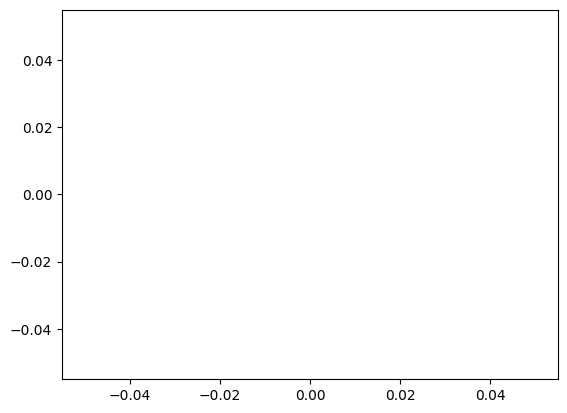

In [ ]:

table = 'COSI_LAT_factors.csv'
percent = 0.1
COSI_LAT_Sources = pd.read_csv(table, sep=",", na_filter=True)
flare_array = []
COSI_BAND_ALL = np.array([0,0,0])
#quiescent_flare_plot(cadence_df,sourcename = COSI_LAT_Sources['Name'][p],percent=0.1,bkg_err=True
for i,s in COSI_LAT_Sources.iterrows():
    print(i)
    Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][i]

    sourcename = COSI_LAT_Sources['Name'][i]

    factor = COSI_LAT_Sources['ph/s_ratio'][i]

    sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
    titlestring=sourcename

    sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
    average_flux = np.mean(sourcearray['photon_flux2'])
    sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

    time = sourcearray['tmin']/SecsInDay + MJDREFI
    photon_flux = sourcearray['photon_flux2']
    errors = sourcearray['photon_flux_error2']

    sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
    maxflux = np.max(photon_flux)
    minflux = np.min(photon_flux)
    delta_flux = maxflux - minflux
    delta_flux_percent = delta_flux * percent
    thresholdflux = minflux + delta_flux_percent
    print(maxflux,minflux,delta_flux,delta_flux_percent,thresholdflux)


    sourcelightcurve.get_bblocks(gamma_value=0.05)
    sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)

    hops_bl = sourcelightcurve.hops
    print(type(hops_bl))

    if type(hops_bl) != list:
        continue
    
    else:
        flarestack = fluence_integrator(hops_bl,sourcelightcurve,time='s')
        print(' ')
        print(flarestack)
        print('aaaaaaa')

        flareintegrals = flarestack[:,1].astype(float)*factor*Aeff
        print(flareintegrals)
        print('bbbbbbbbbbbbb')
        flarenames = flarestack[:,0]
        print(flarenames)
        flareduration = flarestack[:,2]

        COSI_BAND = np.array([flarenames, flareintegrals,flareduration]).T
        print(COSI_BAND)
        print(COSI_BAND_ALL)
        COSI_BAND_ALL = np.vstack((COSI_BAND_ALL, COSI_BAND))


print(COSI_BAND_ALL)

COSI_BAND_ALL_monthly_df=pd.DataFrame(COSI_BAND_ALL)
COSI_BAND_ALL_monthly_df.columns=['Name','Photons','Duration (s)']

COSI_BAND_ALL_monthly_df


In [ ]:
COSI_BAND_ALL_monthly_df = COSI_BAND_ALL_monthly_df[COSI_BAND_ALL_monthly_df[:]['Photons']!='0'].reset_index(drop=True)
COSI_BAND_ALL_monthly_df = COSI_BAND_ALL_monthly_df[COSI_BAND_ALL_monthly_df[:]['Photons']!='0.0'].reset_index(drop=True)
COSI_BAND_ALL_monthly_df['Photons']= COSI_BAND_ALL_monthly_df['Photons'].astype(float)
COSI_BAND_ALL_monthly_df['Duration (s)'] = COSI_BAND_ALL_monthly_df['Duration (s)'].astype(float)
COSI_BAND_ALL_monthly_df

Name       Photons  Duration (s)
0    4FGL J0538.8-4405  88244.455393   147268800.0
1    4FGL J0538.8-4405   2092.085690     9676800.0
2    4FGL J0538.8-4405   5633.924218    26611200.0
3    4FGL J0538.8-4405    818.070769     4233600.0
4    4FGL J0538.8-4405   6319.540038    34776000.0
..                 ...           ...           ...
463  4FGL J0428.6-3756    182.520074     3326400.0
464  4FGL J0428.6-3756   1540.798913    20563200.0
465  4FGL J0428.6-3756   1711.298122    19958400.0
466  4FGL J0428.6-3756    848.200067    10886400.0
467  4FGL J0428.6-3756     48.083457     1209600.0

[468 rows x 3 columns]

In [ ]:
print(COSI_BAND_ALL_monthly_df.dtypes)

Name             object
Photons         float64
Duration (s)    float64
dtype: object


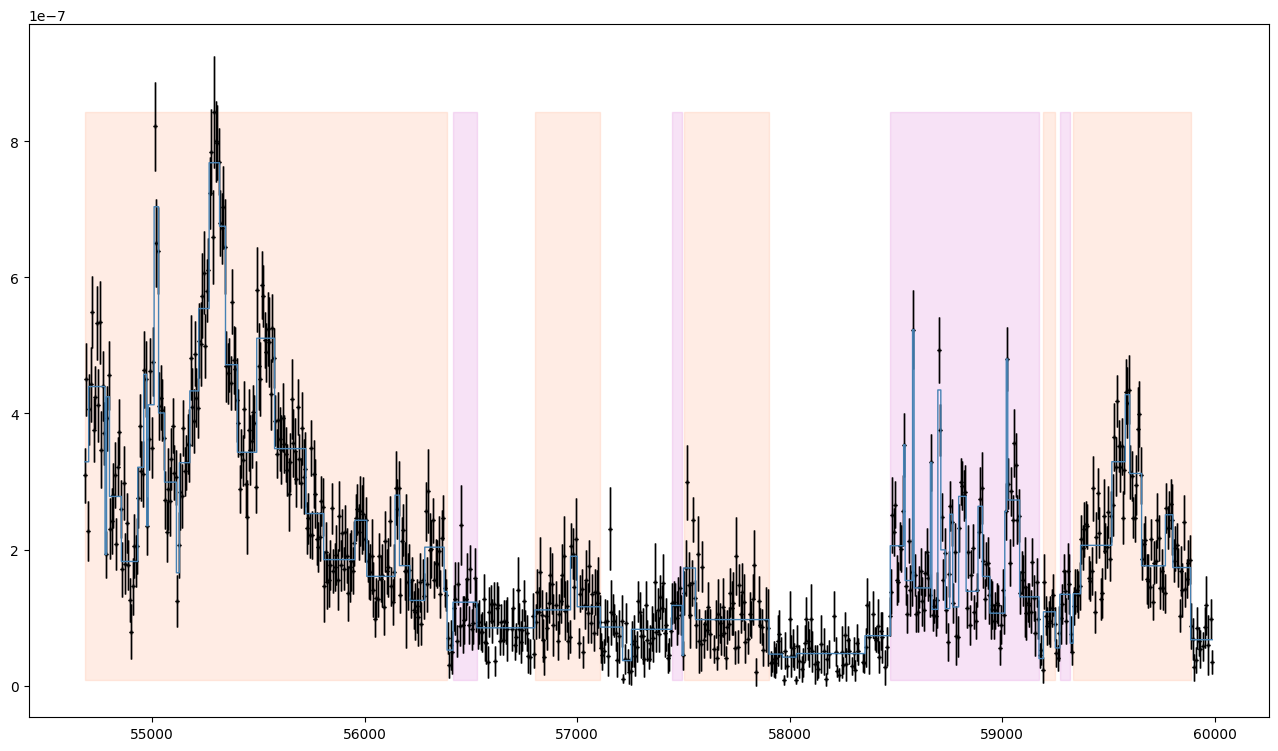

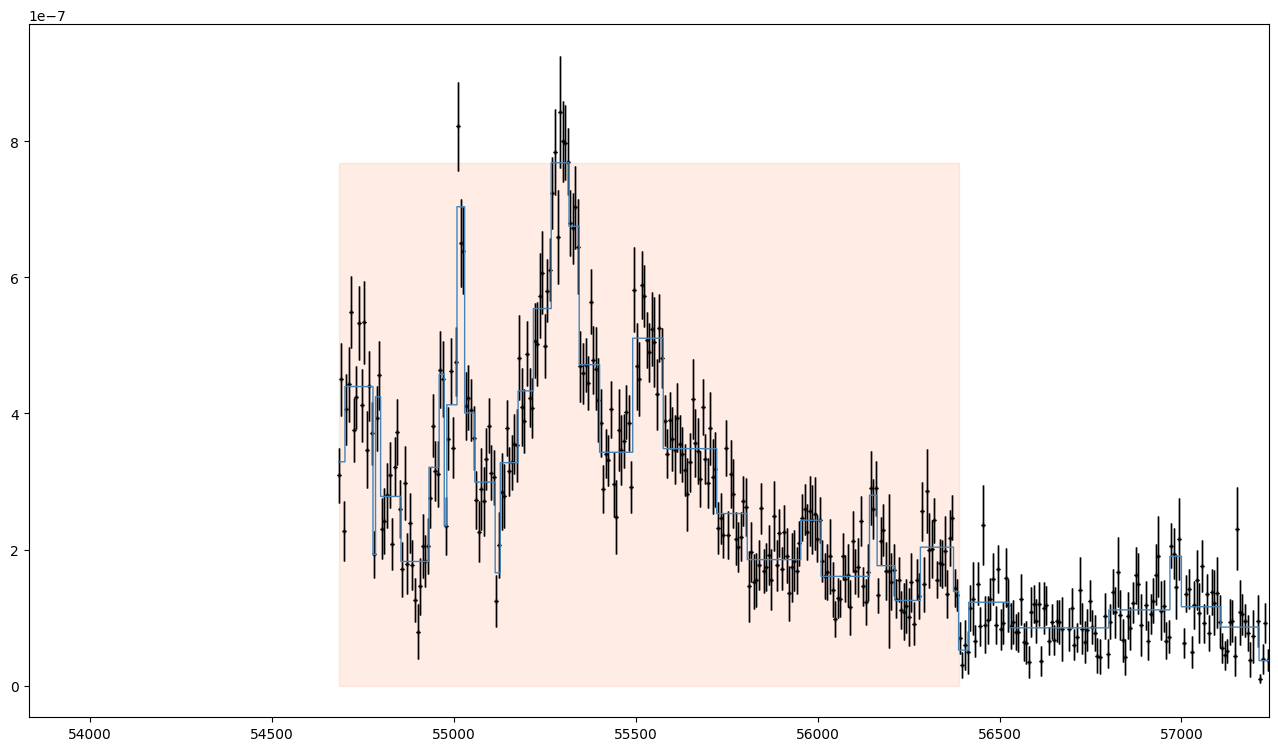

In [ ]:
p = 0
#factor = COSI_LAT_Sources['ph/s_ratio'][p]
factor = 1
percent = 0.1
Aeff = COSI_LAT_Sources['Aeff_mean(cm2)'][p]
sourcename = COSI_LAT_Sources['Name'][p]
sourcearray = cadence_df[cadence_df['source_name'] == sourcename].reset_index(drop=True)
titlestring=sourcename


sourcearray = sourcearray[sourcearray['photon_flux2']!=-3333].reset_index(drop=True)
average_flux = np.mean(sourcearray['photon_flux2'])
sourcearray = sourcearray[sourcearray['photon_flux2']<=100*average_flux].reset_index(drop=True)

time = sourcearray['tmin']/SecsInDay + MJDREFI
photon_flux = sourcearray['photon_flux2'] * factor
errors = sourcearray['photon_flux_error2']

sourcelightcurve = LC.LightCurve(time,photon_flux,errors,time_format='mjd',name=titlestring)
maxflux = np.max(photon_flux)
minflux =np.min(photon_flux)
delta_flux = maxflux - minflux
delta_flux_percent = delta_flux * percent
thresholdflux = minflux + delta_flux_percent


# Finding first set of flares using threshold flux.
plt.figure(figsize=(16,9))
sourcelightcurve.get_bblocks(gamma_value=0.05)
sourcelightcurve.find_hop(method = 'baseline', lc_edges ='add', baseline = thresholdflux)
sourcelightcurve.plot_lc()
sourcelightcurve.plot_bblocks()
sourcelightcurve.plot_hop()

plt.figure(figsize=(16,9))
hops_bl = sourcelightcurve.hops
hops_bl[0].plot_hop()


In [ ]:
len(sourcelightcurve.edge_index)
sourcelightcurve.edge_index
binwidth = np.zeros(len(sourcelightcurve.block_val))
for i in range(0,len(sourcelightcurve.edges)-1):
    binwidth[i] = sourcelightcurve.edge_index[i+1]-sourcelightcurve.edge_index[i]
#rint(len(sourcelightcurve.time),len(sourcelightcurve.block_pbin))
print(binwidth)

[ 3. 11.  1.  2.  8. 11.  4.  2.  1.  4.  3.  4.  8.  2.  7.  6.  7.  7.
  4.  8. 13. 12. 21. 12. 21.  8. 19.  3.  7. 10. 13.  2.  4. 16. 36. 23.
  4. 15. 14.  6. 27.  7.  1.  8. 44.  8.  8. 35. 13.  9.  1.  5.  1. 11.
  1.  4.  2.  3.  3.  2.  4.  5.  8.  3.  5. 10.  1.  1.  8. 13.  3.  8.
  3.  7.  2.  5. 21.  9.  3.  8. 16.  5. 12. 13.]


In [ ]:
midtime = np.zeros(len(sourcelightcurve.edges)-1)
for i in range(0,len(sourcelightcurve.edges)-1):
    midtime[i] = (sourcelightcurve.time[i]+sourcelightcurve.time[i+1])/2
midtime

array([54686.50001157, 54693.50001157, 54700.50001157, 54707.50001157,
       54714.50001157, 54721.50001157, 54728.50001157, 54735.50001157,
       54742.50001157, 54749.50001157, 54756.50001157, 54763.50001157,
       54770.50001157, 54777.50001157, 54784.50001157, 54791.50001157,
       54798.50001157, 54805.50001157, 54812.50001157, 54819.50001157,
       54826.50001157, 54833.50001157, 54840.50001157, 54847.50001157,
       54854.50001157, 54861.50001157, 54868.50001157, 54875.50001157,
       54882.50001157, 54889.50001157, 54896.50001157, 54903.50001157,
       54910.50001157, 54917.50001157, 54924.50001157, 54931.50001157,
       54938.50001157, 54945.50001157, 54952.50001157, 54959.50001157,
       54966.50001157, 54973.50001157, 54980.50001157, 54987.50001157,
       54994.50001157, 55001.50001157, 55008.50001157, 55015.50001157,
       55022.50001157, 55029.50001157, 55036.50001157, 55043.50001157,
       55050.50001157, 55057.50001157, 55064.50001157, 55071.50001157,
      